In [49]:
import sys
sys.path.append("../")

In [50]:
import pandas as pd
import plotly.graph_objects as go
from plotting import CandlePlot
import numpy as np

from simulation.pair_trade_percent_binance import PairTradePercent

from functools import reduce

In [51]:

from multiprocessing import Process, Manager
import pickle
import warnings
warnings.filterwarnings('ignore')

In [100]:

# def calculate_rsi(df, period=14):
#     # Calcula as diferenças dos preços de fechamento
#     df['Price Change'] = df['Close'].diff()
    
#     # Separa ganhos e perdas
#     df['Gain'] = df['Price Change'].apply(lambda x: x if x > 0 else 0)
#     df['Loss'] = df['Price Change'].apply(lambda x: -x if x < 0 else 0)
    
#     # Calcula as médias móveis exponenciais dos ganhos e perdas
#     avg_gain = df['Gain'].rolling(window=period).mean()
#     avg_loss = df['Loss'].rolling(window=period).mean()
    
#     # Calcula o RSI
#     rs = avg_gain / avg_loss
#     df['RSI'] = 100 - (100 / (1 + rs))
    
#     # Limpa colunas temporárias
#     df.drop(columns=['Price Change', 'Gain', 'Loss'], inplace=True)
    
#     return df




# def calculate_adx(df, period=14):
#     # Cálculo de +DM, -DM e TR
#     df['High-Low'] = df['High'] - df['Low']
#     df['High-Close'] = abs(df['High'] - df['Close'].shift(1))
#     df['Low-Close'] = abs(df['Low'] - df['Close'].shift(1))
    
#     df['TR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
#     df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
#                          np.maximum(df['High'] - df['High'].shift(1), 0), 0)
#     df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
#                          np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    
#     # Suavizando os valores de TR, +DM e -DM com média móvel exponencial
#     df['TR_smooth'] = df['TR'].rolling(window=period).sum()
#     df['+DM_smooth'] = df['+DM'].rolling(window=period).sum()
#     df['-DM_smooth'] = df['-DM'].rolling(window=period).sum()
    
#     # Cálculo de +DI e -DI
#     df['+DI'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
#     df['-DI'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
    
#     # Cálculo do DX
#     df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    
#     # Cálculo do ADX
#     df['ADX'] = df['DX'].rolling(window=period).mean()

#     # Limpando colunas temporárias
#     df.drop(columns=['High-Low', 'High-Close', 'Low-Close', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', 'DX'], inplace=True)

#     return df
    
# # Função para calcular a variação percentual acumulada
# def calculate_percent_change(close_prices, window):
#     percent_change = np.zeros(len(close_prices))

#     for i in range(window, len(close_prices)):
#         window_sum = 0.0
#         for j in range(i - window + 1, i + 1):
#             percent_change[j] = (close_prices[j] - close_prices[j - 1]) / close_prices[j - 1] * 100
#             window_sum += percent_change[j]
#         percent_change[i] = window_sum

#     return percent_change


# Função para calcular a variação percentual acumulada com uma janela deslizante correta
def calculate_percent_change(close_prices, window):
    percent_change = np.zeros(len(close_prices))

    for i in range(window, len(close_prices)):
        window_sum = 0.0
        for j in range(i - window + 1, i + 1):
            # Calcula a variação percentual entre o ponto atual e o ponto anterior
            change = (close_prices[j] - close_prices[j - 1]) / close_prices[j - 1] * 100
            window_sum += change
        # Atribui o valor acumulado da janela atual ao ponto final da janela
        percent_change[i] = window_sum

    return percent_change



# Função para calcular a EMA
def calculate_ema(values, period):
    ema = np.zeros(len(values))
    multiplier = 2 / (period + 1)
    ema[period - 1] = values[period - 1]  # O primeiro valor da EMA é igual ao valor inicial
    for i in range(period, len(values)):
        ema[i] = (values[i] - ema[i - 1]) * multiplier + ema[i - 1]
    return ema

# Função para calcular os indicadores e adicionar ao DataFrame
def calculate_indicators(df, window=14, ema_period_1=10, ema_period_2=60):
    
    # Obtém os preços de fechamento da coluna 'mid_c'
    close_prices = df['EMA_short'].values
    # close_prices = df['cLog_Returns'].values
    
    # Calcula a variação percentual acumulada
    percent_change = calculate_percent_change(close_prices, window)

    # Calcula as EMAs
    ema_1 = calculate_ema(percent_change, ema_period_1)
    ema_ema_1 = calculate_ema(ema_1, ema_period_2)
    # ema_2 = calculate_ema(percent_change, ema_period_2)

    # Adiciona os resultados ao DataFrame original
    df['Percent_Change'] = percent_change
    df['EMA_percent_s'] = ema_1
    df['double_EMA_percent_s'] = ema_ema_1
    # df['EMA_percent_l'] = ema_2

    return df


# Função para calcular os indicadores e adicionar ao DataFrame
def calculate_emaper(df, window=14):
    
    # Obtém os preços de fechamento da coluna 'mid_c'
    close_prices = df['EMA_short'].values
    # close_prices = df['cLog_Returns'].values
    
    # Calcula a variação percentual acumulada
    percent_change = calculate_percent_change(close_prices, window)

    # Calcula as EMAs
    # ema_1 = calculate_ema(percent_change, ema_period_1)
    # ema_ema_1 = calculate_ema(ema_1, ema_period_2)
    # ema_2 = calculate_ema(percent_change, ema_period_2)

    # # Adiciona os resultados ao DataFrame original
    # df['Percent_Change'] = percent_change
    # df['EMA_percent_s'] = ema_1
    # df['double_EMA_percent_s'] = ema_ema_1
    # df['EMA_percent_l'] = ema_2

    return percent_change
    


import pandas as pd
import numpy as np

def calculate_rsi(df, period=14):
    # Calcula as diferenças dos preços de fechamento
    delta = df['Close'].diff()
    
    # Separa ganhos e perdas
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    
    # Usa a média móvel exponencial para suavizar os ganhos e perdas
    avg_gain = pd.Series(gain).ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = pd.Series(loss).ewm(alpha=1/period, min_periods=period).mean()
    
    # Calcula o RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    # Adiciona o RSI ao DataFrame e retorna
    df['RSI'] = rsi
    return df

def calculate_adx(df, period=14):
    # Calcula +DM, -DM e TR
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df['+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df['-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Close'].shift(1)), 
                                     abs(df['Low'] - df['Close'].shift(1))))

    # Suaviza TR, +DM e -DM com a média móvel exponencial
    atr = df['TR'].ewm(alpha=1/period, min_periods=period).mean()
    df['+DI'] = 100 * (df['+DM'].ewm(alpha=1/period, min_periods=period).mean() / atr)
    df['-DI'] = 100 * (df['-DM'].ewm(alpha=1/period, min_periods=period).mean() / atr)
    
    # Calcula o DX e o ADX
    dx = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = dx.ewm(alpha=1/period, min_periods=period).mean()

    # Remove colunas temporárias
    df.drop(columns=['+DM', '-DM', 'TR'], inplace=True)
    
    return df


In [132]:
def run_pair(pair,
             granularity,
             ema_s=10,
             ema_l=200,
             lenght=10000,
             window_percent=100,
            ema_percent1=100,
            ema_percent2=100,
             strategy=1,
             EMA_percent_s_force=0.01,
             stop_loss_percent=-0.02,
             rsi_force=70,
             rsi_window=50,
             adx_force=20,
             adx_window=50
            ):
    df = pd.read_pickle(f"crypto/{pair}_{granularity}.pkl")
    df['time'] = df['Time'].copy()
    df['strategy'] = 0
    # dff['returns'] = dff['Close'].pct_change()
    df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['creturns'] = df['returns'].cumsum()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['cLog_Returns'] = df['Log_Returns'].cumsum()

    # df = df.iloc[lenght:]
    df = df[df['Time'] >= lenght]

    df['EMA_short'] = df.Close.ewm(span=ema_s, min_periods=ema_s).mean()
    df['EMA_long'] = df.Close.ewm(span=ema_l, min_periods=ema_l).mean()

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # df = calculate_indicators(df, window_percent, ema_percent1, ema_percent2)

    df['Percent_Change'] = calculate_emaper(df, window_percent)
    df['EMA_percent_s'] = calculate_ema(df['Percent_Change'].values, ema_percent1)
    df['double_EMA_percent_s'] =  calculate_ema(df['EMA_percent_s'].values,ema_percent2)

    df['Percent_Change_2'] = calculate_emaper(df, 50)
    df['EMA_percent_s_2'] = calculate_ema(df['Percent_Change_2'].values, 10)
    
    df['Percent_Change_3'] = calculate_emaper(df, 100)
    df['EMA_percent_s_3'] = calculate_ema(df['Percent_Change_3'].values, 10)

    df['Percent_Change_4'] = calculate_emaper(df, 150)
    df['EMA_percent_s_4'] = calculate_ema(df['Percent_Change_4'].values, 10)

    df = calculate_adx(df, adx_window)
    df = calculate_rsi(df, rsi_window)
    
    df.dropna(inplace=True)
    
    df.reset_index(drop=True, inplace=True)


    

    
    gt = PairTradePercent(
        df,
        strategy,
        EMA_percent_s_force,
        stop_loss_percent,
        rsi_force,
        adx_force
    )
    
    gt.run_test()
    return gt
    

In [133]:
# df = run_pair(pair='BTCUSDT', 
#               granularity='1m', 
#               ema=10,
#               lenght=10000, 
#               pairs_trade_benchmark = ["BTCUSDT",'ETHUSDT','BNBUSDT','LTCUSDT'],
#             window_percent=100,
#             ema_percent1=100,
#             ema_percent2=100,)


In [134]:
# df.columns

In [135]:
# pairs = ["ADAUSDT","BTCUSDT",'ETHUSDT','BNBUSDT','XRPUSDT','LTCUSDT']
pairs = ['XRPUSDT']

In [136]:
def get_list_args():
    args_dic_list = []
    for ema_s in [10]:
        for ema_l in [5000]:
            for pair in pairs:
                for granularity in ['5m','15m']:
                    for lenght in ['2024-01-01 00:00:00']:
                        for window_percent in [10]:
                            for ema_percent1 in [50]:
                                ep2 = [10]
                                for ema_percent2 in ep2:
                                    for EMA_percent_s_force in [0.03]:
                                        slp = [-0.01]
                                        for stop_loss_percent in slp:
                                            for strategy in [1,2,3,13,14]:#,11,12]:
                                                rsi_forces = [50]
                                                rsi_windows = [50]
                                                adx_forces = [20]
                                                adx_windows = [50]
                                                if strategy in [1,2,3]:
                                                    rsi_forces, rsi_windows, adx_forces, adx_windows = [10], [10], [10], [10]
                                                elif strategy in [4,6,8]:
                                                    adx_forces, adx_windows = [10], [10]
                                                elif strategy in [5,7,9]:
                                                    rsi_forces, rsi_windows = [10], [10]
                                                for rsi_force in rsi_forces:
                                                    for rsi_window in rsi_windows:
                                                        for adx_force in adx_forces:
                                                            for adx_window in adx_windows:
                                                            
                                                                args_dic = {"pair": pair,
                                                                            "granularity":granularity,
                                                                            'ema_s': ema_s,
                                                                            'ema_l': ema_l,
                                                                            'lenght': lenght,
                                                                            'window_percent': window_percent,
                                                                           'ema_percent1': ema_percent1,
                                                                           'ema_percent2': ema_percent2,
                                                                            'strategy':strategy,
                                                                           'EMA_percent_s_force':EMA_percent_s_force,
                                                                            'stop_loss_percent':stop_loss_percent,
                                                                           'rsi_force': rsi_force,
                                                                           'rsi_window':rsi_window,
                                                                           'adx_force': adx_force,
                                                                           'adx_window':adx_window}
                                                                args_dic_list.append(args_dic)

    return args_dic_list

In [137]:

def run_process(L, arg):
    # print("PROCESS",arg)
    L.append(
        dict(
            arg=arg,
            pair=arg['pair'],
            granularity=arg['granularity'],
            ema_s=arg['ema_s'],
            ema_l=arg['ema_l'],
            lenght = arg['lenght'],
            window_percent = arg['window_percent'],
            ema_percent1 = arg['ema_percent1'],
            ema_percent2 = arg['ema_percent2'],
            stop_loss_percent = arg['stop_loss_percent'],
            strategy = arg['strategy'],
            rsi_force = arg['rsi_force'],
            rsi_window = arg['rsi_window'],
            adx_force = arg['adx_force'],
            adx_window = arg['adx_window'],
            res=run_pair(
                pair=arg['pair'],
                granularity=arg['granularity'],
                ema_s=arg['ema_s'],
                ema_l=arg['ema_l'],
                lenght = arg['lenght'],
                window_percent = arg['window_percent'],
                ema_percent1 = arg['ema_percent1'],
                ema_percent2= arg['ema_percent2'],
                strategy= arg['strategy'],
                EMA_percent_s_force=arg['EMA_percent_s_force'],
                stop_loss_percent=arg['stop_loss_percent'],
                rsi_force = arg['rsi_force'],
                rsi_window = arg['rsi_window'],
                adx_force=  arg['adx_force'],
                adx_window = arg['adx_window'],
            )
        )
    )


lista = []
def run_ema_macd():
    with Manager() as manager:
        global lista
        L = manager.list()  # <-- can be shared between processes.
        args_list = get_list_args()
        print(len(args_list))
        limit = 10
        current = 0
    
        while current < len(args_list):
            print(current)
            processes = []
            todo = len(args_list) - current
            if todo < limit:
                limit = todo
    
            for _ in range(limit):
                processes.append(Process(target=run_process, args=(L,args_list[current])))
                current += 1
    
            for p in processes:
                p.start()
    
            for p in processes:
                p.join()

        print("ALL DONE")
        lista = list(L)
        

In [138]:
%%time

run_ema_macd()

10
0
ALL DONE
CPU times: user 67.2 ms, sys: 319 ms, total: 386 ms
Wall time: 10.8 s


In [139]:
# with open(f"./result-binance-acumulative-percentual.pkl", "wb") as f:
#     pickle.dump(lista, f)  # Usa o pickle para salvar o arquivo

In [140]:
# ddf.columns

In [141]:
# ddf.describe()

In [142]:
res = lista


In [143]:

dic_res = []
for r in res:

    if r['res'].len_close > 1:
        signal_up = r['res'].df_results.SIGNAL_UP.values[-1]
        res_pos = r['res'].df_results[r['res'].df_results['result'] > 0]
        res_neg = r['res'].df_results[r['res'].df_results['result'] <= 0]
        sum_neg = res_neg.result.sum() * -1
        sum_pos = res_pos.result.sum()

        res_pos_s = r['res'].df_results[r['res'].df_results['strategy'] > 0]
        res_neg_s = r['res'].df_results[r['res'].df_results['strategy'] <= 0]
        sum_neg_s = res_neg_s.strategy.sum() *-1
        sum_pos_s = res_pos_s.strategy.sum()
        dic_res.append(
            dict(
                pair = r['pair'],
                granularity = r['granularity'],
                ema_s = r['ema_s'],
                ema_l = r['ema_l'],
                strat = round(r['res'].df_results.strategy.sum(),3),
                res = round(r['res'].df_results.result.sum(),3),
                sig = signal_up,
                c = r['res'].df_results['count'].mean(),
                wp = r['window_percent'],
                ep = r['ema_percent1'],
                double_ep = r['ema_percent2'],
                rsi_f = r['rsi_force'],
                rsi_w = r['rsi_window'],
                adx_f = r['adx_force'],
                adx_w = r['adx_window'],
                
                max_o = max(r['res'].df_results.total_opened),
                st = r['res'].strategy,
                force = r['res'].EMA_percent_s_force,
                sl_per = r['res'].stop_loss_percent,
                s_p_strat = sum_pos_s,
                s_n_strat = sum_neg_s,
                Rel_sum = sum_pos_s/(sum_pos_s+ sum_neg_s),
                
                l_p_strat = len(res_pos_s),
                l_n_strat = len(res_neg_s),
                Rel_len = len(res_pos_s)/(len(res_pos_s)+ len(res_neg_s)),
                
                l_c = r['res'].len_close,
                l_o = r['res'].len_open,
                   
                len_pos = len(res_pos),
                len_neg = len(res_neg),
                sum_pos = sum_pos,
                sum_neg = sum_neg,
                Rel_len_pos_neg = len(res_pos)/(len(res_pos)+ len(res_neg)),
                Rel_pos_neg = sum_pos/(sum_pos+ sum_neg),

                first_p = r['res'].first_price,
                last_p = r['res'].last_price,

                first_t = r['res'].df_results.start_time.values[0],
                last_t = r['res'].df_results.end_time.values[-1],
                
                r = r['res'].df_results,
                df = r['res'].df
            )
    )
    # print(f"p={p}  e={e}  dw={dw}  dwp={dwp}   strategy={st}   result={result}")


In [144]:
pd.set_option('display.max_columns', None)

df_res = pd.DataFrame(dic_res)



print(df_res.columns)




Index(['pair', 'granularity', 'ema_s', 'ema_l', 'strat', 'res', 'sig', 'c',
       'wp', 'ep', 'double_ep', 'rsi_f', 'rsi_w', 'adx_f', 'adx_w', 'max_o',
       'st', 'force', 'sl_per', 's_p_strat', 's_n_strat', 'Rel_sum',
       'l_p_strat', 'l_n_strat', 'Rel_len', 'l_c', 'l_o', 'len_pos', 'len_neg',
       'sum_pos', 'sum_neg', 'Rel_len_pos_neg', 'Rel_pos_neg', 'first_p',
       'last_p', 'first_t', 'last_t', 'r', 'df'],
      dtype='object')


In [145]:
pd.set_option('display.max_rows', None)

In [146]:
df_res_test = df_res.copy()

df_res_test = df_res_test.sort_values(by=['pair','strat'], ascending=False).reset_index(drop=True)
df_res_test[['pair', 'granularity', 'strat', 'res', 'c',
        'ep','wp','double_ep', 'max_o', 'st', 'force',
       'sl_per', 's_p_strat', 's_n_strat', 'Rel_sum', 'l_p_strat', 'l_n_strat',
       'Rel_len', 'l_c', 'l_o', 'len_pos', 'len_neg', 'sum_pos', 'sum_neg',
       'Rel_len_pos_neg', 'Rel_pos_neg', 'first_p', 'last_p', 'first_t',
       'last_t', 'r']].head(50)

pair granularity  strat    res          c  ep  wp  double_ep  max_o  st  \
0  XRPUSDT         15m -0.196 -0.006  28.070000  50  10         10      1   1   
1  XRPUSDT         15m -0.207 -0.007  19.475000  50  10         10      1   3   
2  XRPUSDT         15m -0.349 -0.109  50.245000  50  10         10      1   2   
3  XRPUSDT         15m -0.570  0.020  24.061889  50  10         10      2  14   
4  XRPUSDT          5m -0.845 -0.104  24.076324  50  10         10      1   3   
5  XRPUSDT         15m -0.865 -0.166  18.236156  50  10         10      2  13   
6  XRPUSDT          5m -0.972 -0.167  32.764798  50  10         10      1   1   
7  XRPUSDT          5m -1.023 -0.224  55.429907  50  10         10      1   2   
8  XRPUSDT          5m -1.666  0.225  26.315553  50  10         10      2  14   
9  XRPUSDT          5m -2.204 -0.148  22.375685  50  10         10      2  13   

   force  sl_per  s_p_strat  s_n_strat   Rel_sum  l_p_strat  l_n_strat  \
0   0.03   -0.01   0.980370   1.176752  0.454480         83        117   
1   0.03   -0.01   0.839107   1.046270  0.445061        107         93   
2   0.03   -0.01   1.098080   1.446986  0.431455         66        134   
3   0.03   -0.01   2.880763   3.450278  0.455022        210        404   
4   0.03   -0.01   1.444960   2.290076  0.386866        318        324   
5   0.03   -0.01   2.642012   3.507036  0.429662        295        319   
6   0.03   -0.01   1.752967   2.725100  0.391456        258        384   
7   0.03   -0.01   2.257244   3.280713  0.407595        199        443   
8   0.03   -0.01   5.958063   7.624151  0.438667        700       1306   
9   0.03   -0.01   5.216344   7.420509  0.412788       1029        978   

    Rel_len   l_c  l_o  len_pos  len_neg  sum_pos  sum_neg  Rel_len_pos_neg  \
0  0.415000   200    0       94      106   0.5917   0.5976         0.470000   
1  0.535000   200    0      113       87   0.5279   0.5346         0.565000   
2  0.330000   200    0       73      127   0.6369   0.7458         0.365000   
3  0.342020   614    0      234      380   1.7334   1.7137         0.381107   
4  0.495327   642    0      363      279   0.9981   1.1024         0.565421   
5  0.480456   614    0      313      301   1.6393   1.8055         0.509772   
6  0.401869   642    0      293      349   1.1447   1.3119         0.456386   
7  0.309969   642    0      232      410   1.3651   1.5889         0.361371   
8  0.348953  2006    1      789     1217   3.7528   3.5278         0.393320   
9  0.512706  2007    0     1139      868   3.4891   3.6368         0.567514   

   Rel_pos_neg  first_p  last_p             first_t              last_t  \
0     0.497520   0.5424  0.6142 2024-02-23 02:00:00 2024-09-30 14:15:00   
1     0.496847   0.5424  0.6142 2024-02-23 02:00:00 2024-09-30 14:15:00   
2     0.460621   0.5424  0.6142 2024-02-23 02:00:00 2024-09-30 14:15:00   
3     0.502857   0.5419  0.6142 2024-02-23 06:00:00 2024-09-30 23:45:00   
4     0.475173   0.5651  0.6127 2024-01-19 00:20:00 2024-09-30 14:10:00   
5     0.475877   0.5419  0.6142 2024-02-23 06:00:00 2024-10-01 00:00:00   
6     0.465969   0.5651  0.6127 2024-01-19 00:20:00 2024-09-30 14:10:00   
7     0.462119   0.5651  0.6127 2024-01-19 00:20:00 2024-09-30 14:10:00   
8     0.515452   0.5547  0.6127 2024-01-18 19:00:00 2024-09-30 22:00:00   
9     0.489636   0.5547  0.6127 2024-01-18 19:00:00 2024-09-30 23:05:00   

                                                   r  
0       running  start_index_m5  count  trigger_t...  
1       running  start_index_m5  count  trigger_t...  
2       running  start_index_m5  count  trigger_t...  
3       running  start_index_m5  count  trigger_t...  
4       running  start_index_m5  count  trigger_t...  
5       running  start_index_m5  count  trigger_t...  
6       running  start_index_m5  count  trigger_t...  
7       running  start_index_m5  count  trigger_t...  
8        running  start_index_m5  count  trigger_...  
9        running  start_index_m5  count  trigger_...

In [147]:

df_result = df_res_test.iloc[0].r
df_result.describe()

start_index_m5      count  trigger_type    strategy  strategy_no_tc  \
count      200.000000  200.00000         200.0  200.000000      200.000000   
mean     10576.715000   28.07000           1.0   -0.000982        0.000018   
min         78.000000    2.00000           1.0   -0.076188       -0.075188   
25%       5399.750000   16.00000           1.0   -0.009468       -0.008468   
50%      10285.500000   24.00000           1.0   -0.002288       -0.001288   
75%      15752.250000   37.25000           1.0    0.006211        0.007211   
max      21244.000000   98.00000           1.0    0.061293        0.062293   
std       6086.710801   18.52189           0.0    0.015297        0.015297   

       total_opened  trail_stop  trail_stop_target  start_price  \
count         200.0       200.0              200.0   200.000000   
mean            1.0        -1.0                0.0     0.553868   
min             1.0        -1.0                0.0     0.424500   
25%             1.0        -1.0                0.0     0.517850   
50%             1.0        -1.0                0.0     0.547850   
75%             1.0        -1.0                0.0     0.597025   
max             1.0        -1.0                0.0     0.704300   
std             0.0         0.0                0.0     0.054660   

       trigger_price  SIGNAL_UP  SIGNAL_DOWN      result  \
count     200.000000  200.00000    200.00000  200.000000   
mean        0.554111    0.49500      0.50500   -0.000030   
min         0.428200    0.00000      0.00000   -0.041800   
25%         0.516775    0.00000      0.00000   -0.004700   
50%         0.547650    0.00000      1.00000   -0.000700   
75%         0.599025    1.00000      1.00000    0.003875   
max         0.697400    1.00000      1.00000    0.035100   
std         0.054913    0.50123      0.50123    0.008616   

                         end_time                  start_time  
count                         200                         200  
mean   2024-06-11 17:26:46.500000  2024-06-11 10:40:43.500000  
min           2024-02-23 02:45:00         2024-02-23 02:00:00  
25%           2024-04-19 00:00:00         2024-04-18 12:26:15  
50%           2024-06-08 23:15:00         2024-06-08 09:52:30  
75%           2024-08-04 17:18:45         2024-08-04 08:33:45  
max           2024-09-30 14:15:00         2024-09-30 13:30:00  
std                           NaN                         NaN

In [148]:
df_result.sort_values(by='start_time').head()

running  start_index_m5  count  trigger_type  strategy  strategy_no_tc  \
0    False              78      4             1 -0.007477       -0.006477   
1    False             160     21             1 -0.006233       -0.005233   
2    False             321     30             1 -0.005407       -0.004407   
3    False             419      2             1 -0.001556       -0.000556   
4    False             636     44             1  0.032038        0.033038   

   total_opened  first_return  trail_stop  trail_stop_target  start_price  \
0             1         False          -1                  0       0.5421   
1             1         False          -1                  0       0.5337   
2             1         False          -1                  0       0.5458   
3             1         False          -1                  0       0.5402   
4             1         False          -1                  0       0.5716   

   trigger_price  SIGNAL_UP  SIGNAL_DOWN  result            end_time  \
0         0.5386          1            0 -0.0035 2024-02-23 02:45:00   
1         0.5365          0            1 -0.0028 2024-02-24 03:30:00   
2         0.5434          1            0 -0.0024 2024-02-25 22:00:00   
3         0.5399          1            0 -0.0003 2024-02-26 15:30:00   
4         0.5908          1            0  0.0192 2024-02-29 08:15:00   

           start_time  
0 2024-02-23 02:00:00  
1 2024-02-23 22:30:00  
2 2024-02-25 14:45:00  
3 2024-02-26 15:15:00  
4 2024-02-28 21:30:00

In [149]:
# ddf = lista[3]['res'].df.copy()
# ddf = lista[0]['res'].copy()
ddf = df_res_test.iloc[0]['df'].copy()
ddf.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'time', 'strategy',
       'returns', 'creturns', 'Log_Returns', 'cLog_Returns', 'EMA_short',
       'EMA_long', 'Percent_Change', 'EMA_percent_s', 'double_EMA_percent_s',
       'Percent_Change_2', 'EMA_percent_s_2', 'Percent_Change_3',
       'EMA_percent_s_3', 'Percent_Change_4', 'EMA_percent_s_4', '+DI', '-DI',
       'ADX', 'RSI', 'SIGNAL_UP', 'SIGNAL_DOWN'],
      dtype='object')

In [159]:

cp = CandlePlot(ddf.iloc[0000:20000],candles=False)


trades_up = cp.df_plot[cp.df_plot.SIGNAL_UP == 1]

trades_down = cp.df_plot[cp.df_plot.SIGNAL_DOWN == 1]

print(len(trades_up),len(trades_down))

3645 4662


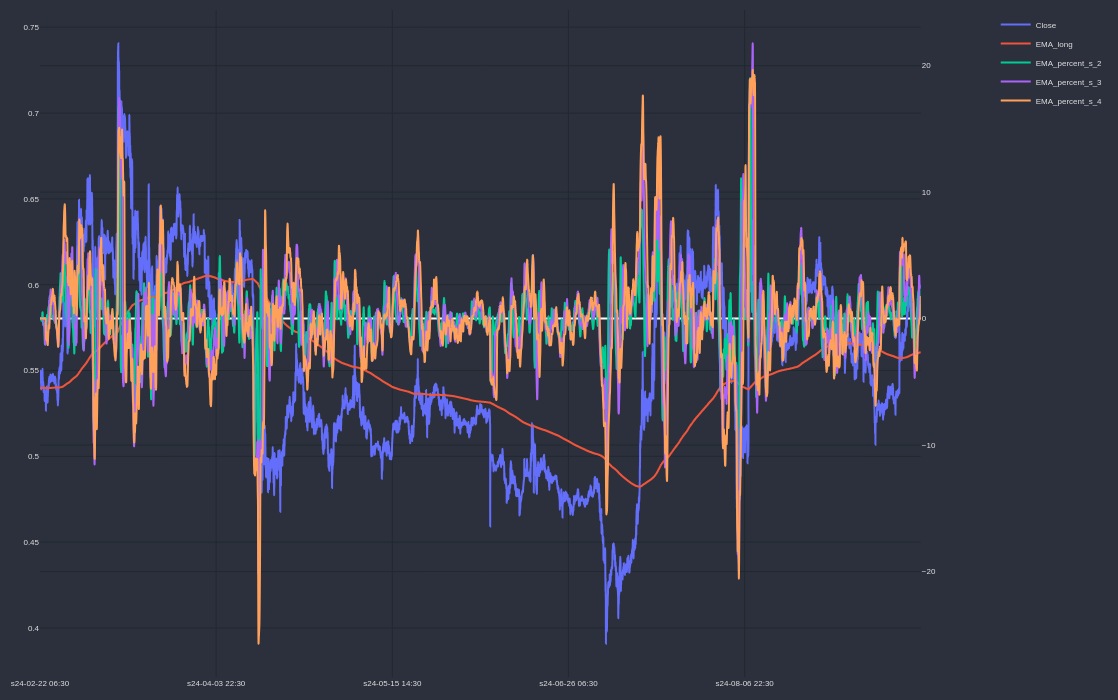

In [160]:

marker_trade_up = '#abebc6'
marker_trade_down = '#cccddd'


markers = 'Close'


cp.add_traces(['Close','EMA_long'])


# # # SIGNAL UP
# cp.fig.add_trace(go.Scatter(
#     x = trades_up.sTime,
#     y = trades_up[markers],
#     mode = 'markers',
#     marker_symbol = 'triangle-up',
#     marker=dict(color=marker_trade_up, size=12)
# ))

# cp.fig.add_trace(go.Scatter(
#     x = trades_down.sTime,
#     y = trades_down[markers],
#     mode = 'markers',
#     marker_symbol = 'triangle-down',
#     marker=dict(color=marker_trade_down, size=12)
# ))


cp.show_plot(height=700, width=1100, sec_traces=['EMA_percent_s_2','EMA_percent_s_3','EMA_percent_s_4'])

In [128]:
# cp = CandlePlot(ddf.iloc[0:20000],candles=False, is_subplots=True)

# cp.add_traces(['RSI'])
# cp.show_plot(height=700, width=1100, sec_traces=['ADX'])

In [30]:
df_result.columns

Index(['running', 'start_index_m5', 'count', 'trigger_type', 'strategy',
       'total_opened', 'first_return', 'trail_stop', 'trail_stop_target',
       'start_price', 'trigger_price', 'SIGNAL_UP', 'SIGNAL_DOWN', 'result',
       'end_time', 'start_time'],
      dtype='object')

In [31]:
df_result[df_result['start_time'] == '2024-09-27 02:33:00']

running  start_index_m5  count  trigger_type  strategy  total_opened  \
344    False          193394      6             1 -0.000942             6   

     first_return  trail_stop  trail_stop_target  start_price  trigger_price  \
344         False           1                  0     64968.21       64906.97   

     SIGNAL_UP  SIGNAL_DOWN  result            end_time          start_time  
344          1            0     0.0 2024-09-27 02:38:00 2024-09-27 02:33:00

In [32]:
df = res[0]['res'].df
df.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'time', 'strategy',
       'returns', 'creturns', 'Log_Returns', 'cLog_Returns', 'EMA_short',
       'EMA_long', 'diff_close_ema_log', 'norm_diff_close_ema_log',
       'diff_abs_close_ema_log', 'norm_diff_abs_close_ema_log',
       'Percent_Change', 'EMA_percent_s', 'EMA_percent_l',
       'norm_EMA_percent_s', 'SIGNAL_UP', 'SIGNAL_DOWN'],
      dtype='object')

In [33]:
index = df[df['time']=='2024-09-27 02:33:00'].index[0]
print(index)

193394


In [34]:
df_test = df.iloc[index:index+20]
df_test['strategy'] = df_test.returns.cumsum()
df_test['strategy2'] = (1 + df_test['returns']).cumprod() - 1
df_test[['Time', 'Close', 'Volume', 'strategy','strategy2','returns']]

Time     Close    Volume  strategy  strategy2  \
193394 2024-09-27 02:33:00  64968.21  17.29385  0.000896   0.000896   
193395 2024-09-27 02:34:00  64970.52   2.89256  0.000932   0.000932   
193396 2024-09-27 02:35:00  64978.01   4.99901  0.001047   0.001047   
193397 2024-09-27 02:36:00  64968.25   9.78177  0.000897   0.000897   
193398 2024-09-27 02:37:00  64953.33   4.92568  0.000667   0.000667   
193399 2024-09-27 02:38:00  64906.97  11.18005 -0.000047  -0.000048   
193400 2024-09-27 02:39:00  64919.99   5.39510  0.000154   0.000153   
193401 2024-09-27 02:40:00  64966.00  22.77322  0.000862   0.000862   
193402 2024-09-27 02:41:00  64962.00  14.08988  0.000801   0.000800   
193403 2024-09-27 02:42:00  64962.01   3.24415  0.000801   0.000800   
193404 2024-09-27 02:43:00  64936.48   3.88459  0.000408   0.000407   
193405 2024-09-27 02:44:00  64959.98   6.76020  0.000770   0.000769   
193406 2024-09-27 02:45:00  64952.51  12.07557  0.000655   0.000654   
193407 2024-09-27 02:46:00  64938.02   2.98984  0.000431   0.000430   
193408 2024-09-27 02:47:00  64955.99   5.17870  0.000708   0.000707   
193409 2024-09-27 02:48:00  64942.49   2.97631  0.000500   0.000499   
193410 2024-09-27 02:49:00  64947.77  13.71117  0.000582   0.000581   
193411 2024-09-27 02:50:00  64949.78   5.06850  0.000613   0.000611   
193412 2024-09-27 02:51:00  64939.25   7.64088  0.000450   0.000449   
193413 2024-09-27 02:52:00  64902.32  11.05089 -0.000118  -0.000120   

             returns  
193394  8.962242e-04  
193395  3.555522e-05  
193396  1.152764e-04  
193397 -1.502159e-04  
193398 -2.296770e-04  
193399 -7.139981e-04  
193400  2.005747e-04  
193401  7.084675e-04  
193402 -6.157256e-05  
193403  1.539361e-07  
193404 -3.930762e-04  
193405  3.618266e-04  
193406 -1.150005e-04  
193407 -2.231110e-04  
193408  2.766871e-04  
193409 -2.078546e-04  
193410  8.129940e-05  
193411  3.094747e-05  
193412 -1.621384e-04  
193413 -5.688471e-04

In [33]:
result = df_test['Close'].iloc[-1] - df_test['Close'].iloc[0]
round(result,4)

np.float64(-0.0002)